In [1]:
import json

from pathlib import Path
from data_utils import get_images, get_labels
import re
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
from sklearn.ensemble import IsolationForest

In [2]:
# Getting local data path from config

with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = Path(config['data_dir'])

# Show all files in the data dir
list(data_dir.glob("*"))

[PosixPath('satellite-image-data/midwest-flooding'),
 PosixPath('satellite-image-data/hurricane-matthew'),
 PosixPath('satellite-image-data/socal-fire'),
 PosixPath('satellite-image-data/test_images_flooding-fire.npz'),
 PosixPath('satellite-image-data/test_images_hurricane-matthew.npz')]

In [3]:
# Look at Hurricane-matthew
disaster = "hurricane-matthew"
split = "train"

# Load train data
train_images = get_images(data_dir, disaster, split=split)
train_labels = get_labels(data_dir, disaster, split=split)

print("Training data type:", type(train_images))
print("Training label type:", type(train_labels))

Training data type: <class 'list'>
Training label type: <class 'numpy.ndarray'>


In [4]:
# See type of element in train_images
type(train_images[0])

numpy.ndarray

In [5]:
# How many images are there? how many labels?

print(len(train_images))

assert len(train_images) == len(train_labels)

11151


In [6]:
# What are the shapes of each image? Are they uniform?
image_shapes = set()

for img in train_images:
    image_shapes.add(tuple(img.shape))

print(f"There are {len(image_shapes)} different sizes of images")

print("example is:", next(iter(image_shapes)))

There are 5147 different sizes of images
example is: (120, 42, 3)


In [7]:
# Do all of them have 3 color channels?
image_shapes = np.asarray(list(image_shapes))

print("Image shapes without color:")
image_shapes[image_shapes[:,2] != 3]

Image shapes without color:


array([], shape=(0, 3), dtype=int64)

In [8]:
# What is the tallest/widest image?

print("Tallest image:")
print(image_shapes[:,0].max())

print("Widest image:")
print(image_shapes[:,1].max())

Tallest image:
354
Widest image:
396


In [9]:
# What is the shortest/skinniest image?

print("Shortest image:")
print(image_shapes[:,0].min())

print("Skinniest image:")
print(image_shapes[:,1].min())

Shortest image:
3
Skinniest image:
4


IMAGE 112 IS TINY?!


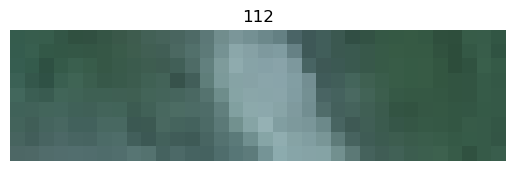

IMAGE 217 IS TINY?!


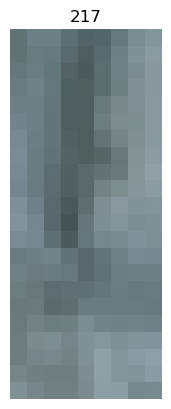

IMAGE 442 IS TINY?!


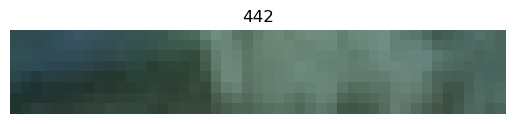

IMAGE 443 IS TINY?!


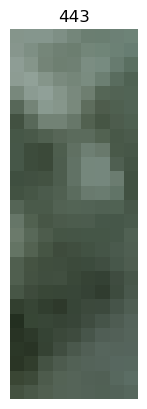

IMAGE 530 IS TINY?!


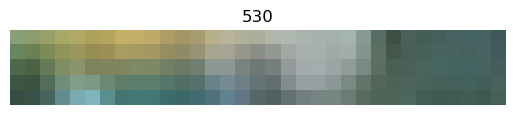

IMAGE 684 IS TINY?!


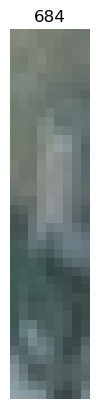

IMAGE 707 IS TINY?!


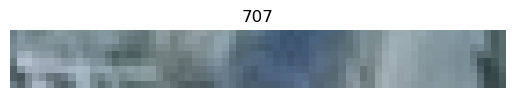

IMAGE 767 IS TINY?!


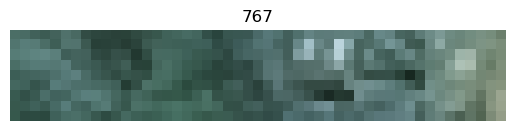

IMAGE 1051 IS TINY?!


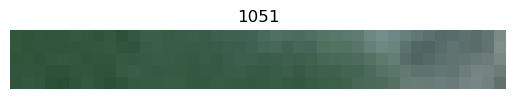

IMAGE 1160 IS TINY?!


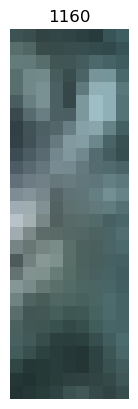

IMAGE 1381 IS TINY?!


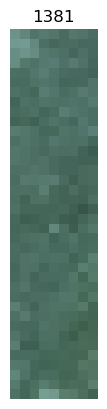

IMAGE 1470 IS TINY?!


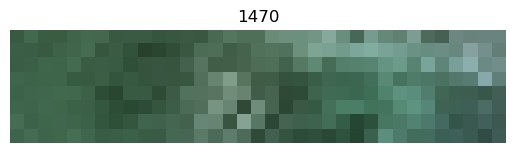

IMAGE 1580 IS TINY?!


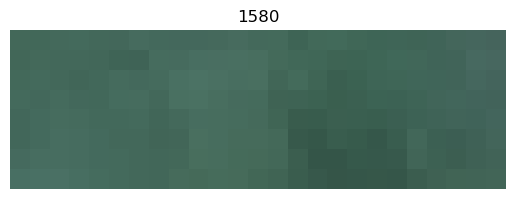

IMAGE 2013 IS TINY?!


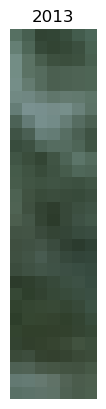

IMAGE 2443 IS TINY?!


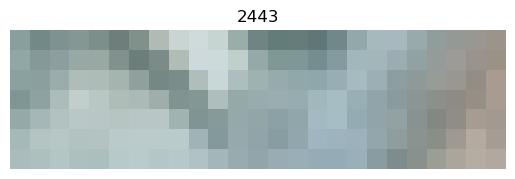

IMAGE 2531 IS TINY?!


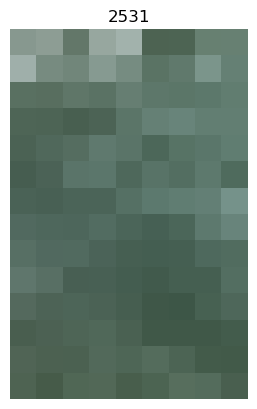

IMAGE 2834 IS TINY?!


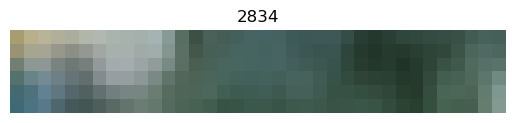

IMAGE 3336 IS TINY?!


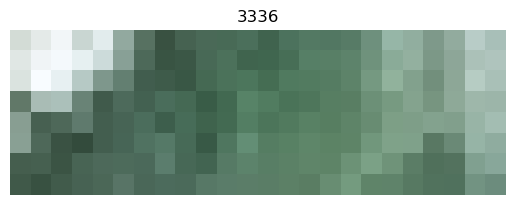

IMAGE 3438 IS TINY?!


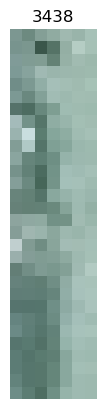

IMAGE 3550 IS TINY?!


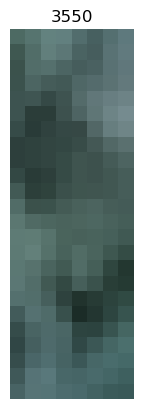

IMAGE 3614 IS TINY?!


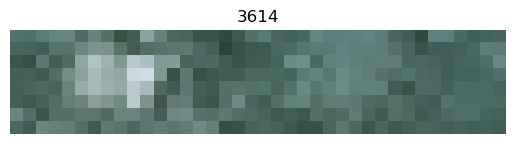

IMAGE 3815 IS TINY?!


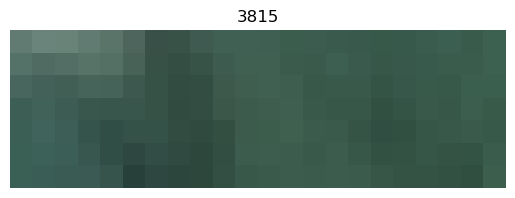

IMAGE 3881 IS TINY?!


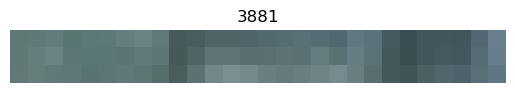

IMAGE 4362 IS TINY?!


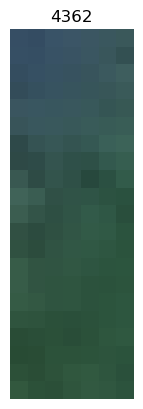

IMAGE 4528 IS TINY?!


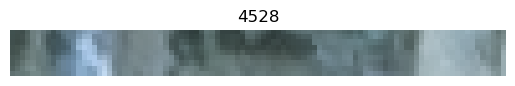

IMAGE 5305 IS TINY?!


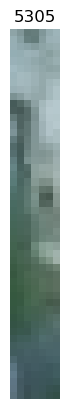

IMAGE 5441 IS TINY?!


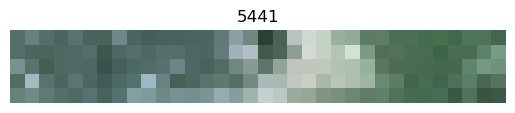

IMAGE 5590 IS TINY?!


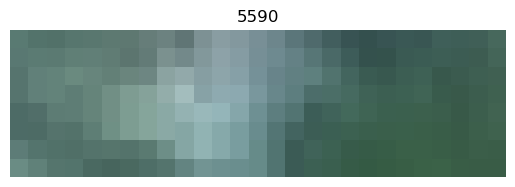

IMAGE 5813 IS TINY?!


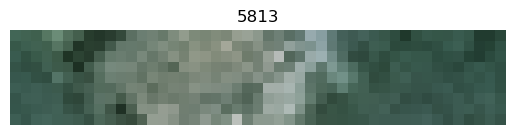

IMAGE 6011 IS TINY?!


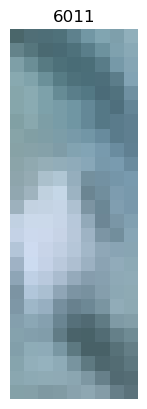

IMAGE 6462 IS TINY?!


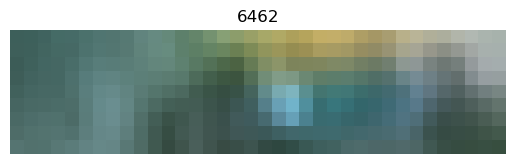

IMAGE 6633 IS TINY?!


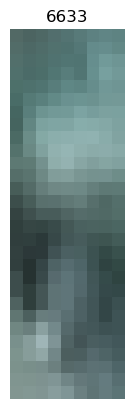

IMAGE 7263 IS TINY?!


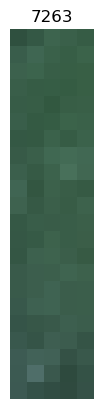

IMAGE 8361 IS TINY?!


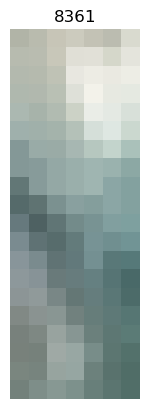

IMAGE 8410 IS TINY?!


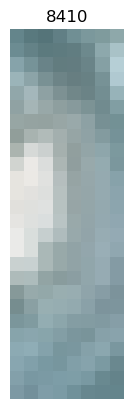

IMAGE 8632 IS TINY?!


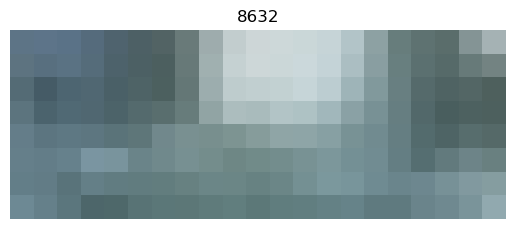

IMAGE 8712 IS TINY?!


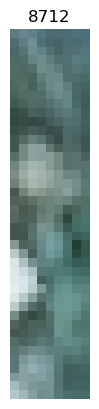

IMAGE 8842 IS TINY?!


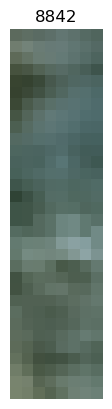

IMAGE 8948 IS TINY?!


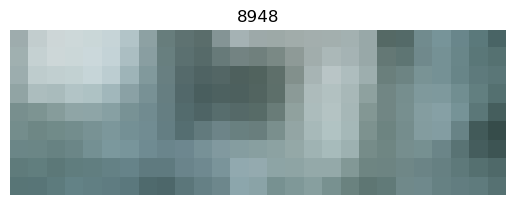

IMAGE 9114 IS TINY?!


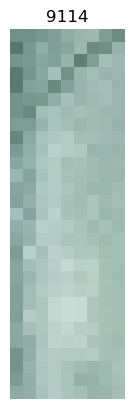

IMAGE 9463 IS TINY?!


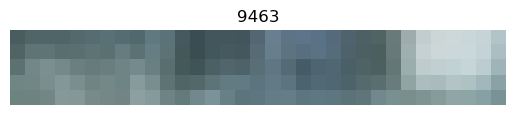

IMAGE 9716 IS TINY?!


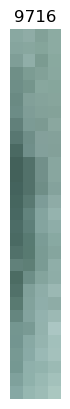

IMAGE 9830 IS TINY?!


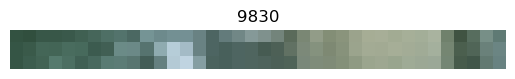

IMAGE 11052 IS TINY?!


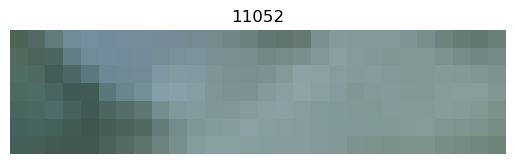

IMAGE 11080 IS TINY?!


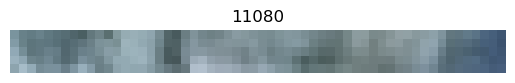

IMAGE 11096 IS TINY?!


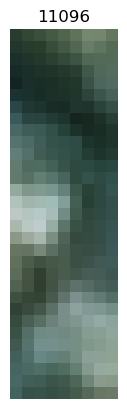

In [10]:
# really? an image thats only 3 pixes tall, or 4 pixels wide?

count = 0

for idx, img in enumerate(train_images):
    if img.shape[0] < 10 or img.shape[1] < 10:

        print(f"IMAGE {idx} IS TINY?!")
        
        plt.title(f"{idx}")
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.show()

        count += 1

In [11]:
print(count, "TINY IMAGES FOUND OUT OF", len(train_images))

46 TINY IMAGES FOUND OUT OF 11151


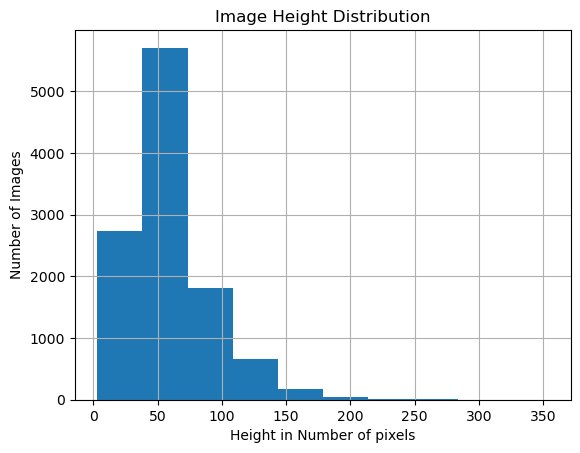

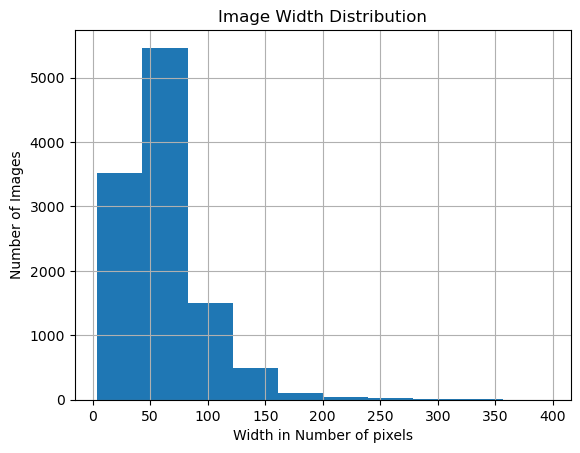

In [12]:
# We will either need to crop, resize, or intentionally 
# use a model that doesn't care about image size


# to decide which route to take, we can start by seeing
# what does the overall distribution of sizes look like?

all_image_shapes = np.array([i.shape for i in train_images])

heights = pd.Series(all_image_shapes[:,0])
heights.hist()
plt.title("Image Height Distribution")
plt.ylabel('Number of Images')
plt.xlabel('Height in Number of pixels')
plt.savefig("Image Height Distribution.png")
plt.show()


widths = pd.Series(all_image_shapes[:,1])
widths.hist()
plt.title("Image Width Distribution")
plt.ylabel('Number of Images')
plt.xlabel('Width in Number of pixels')
plt.savefig("Image Weight Distribution.png")
plt.show()


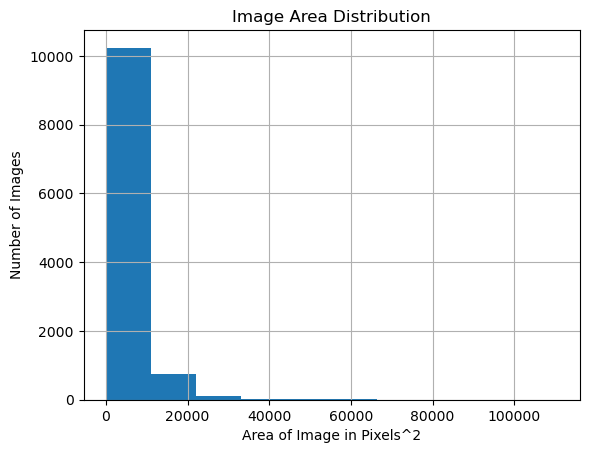

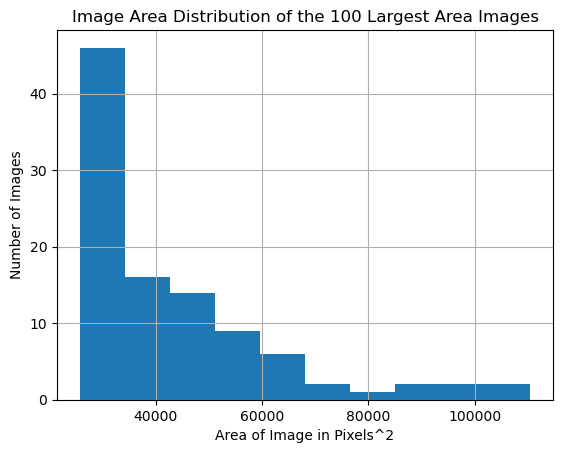

In [13]:
# Most images fall in 50-100 pixels in width or height
# But is this all 1x50 and 50x1 images?

# Next look at the total area - should be around 50*50 if images are mostly square

(widths * heights).hist()
plt.title("Image Area Distribution")
plt.xlabel('Area of Image in Pixels^2')
plt.ylabel('Number of Images')
plt.show();

(widths * heights).sort_values().tail(100).hist()
plt.title("Image Area Distribution of the 100 Largest Area Images")
plt.xlabel('Area of Image in Pixels^2')
plt.ylabel('Number of Images')
plt.show();

In [14]:
# Based on this we don't have square images
# So it may be valuable to transform out images so the longer side
# is always on the bottom

def orient_landscape(img):

    if img.shape[0] < img.shape[1]:
        return img.swapaxes(0, 1)
    else:
        return img

# Check it works on random set from training
if False:
    for img_idx in np.random.choice(range(len(train_images)), 10):
        img = train_images[img_idx]
        
        original_shape = img.shape
    
        sorted_dim = sorted([original_shape[0], original_shape[1]], reverse=True)
        expected_shape = (sorted_dim[0], sorted_dim[1], original_shape[2])
    
        trans = orient_landscape(img)
    
        assert trans.shape == expected_shape, f"{expected_shape}, {trans.shape}"

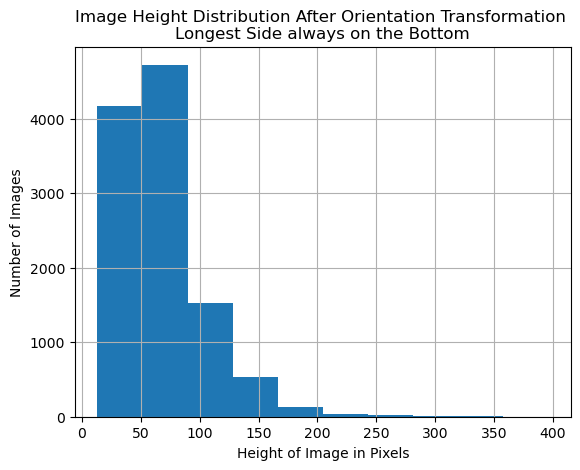

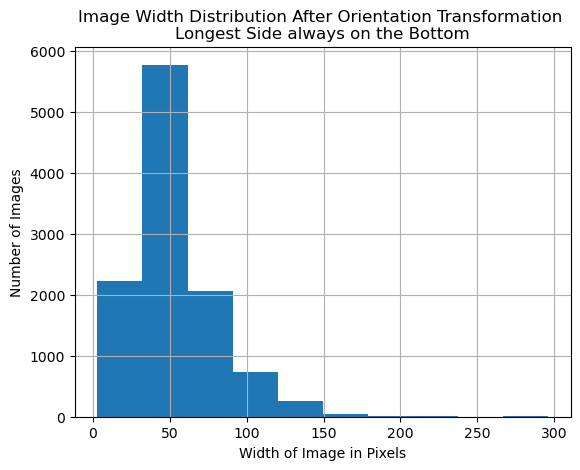

In [15]:
# Apply this transformation and re-assess the dimension distributions

train_images = list(map(orient_landscape, train_images))

all_image_shapes = np.array([i.shape for i in train_images])

heights = pd.Series(all_image_shapes[:,0])
heights.hist()
plt.title("Image Height Distribution After Orientation Transformation \n"
          + "Longest Side always on the Bottom")
plt.xlabel('Height of Image in Pixels')
plt.ylabel('Number of Images')
plt.show()


widths = pd.Series(all_image_shapes[:,1])
widths.hist()
plt.title("Image Width Distribution After Orientation Transformation \n"
          + "Longest Side always on the Bottom")
plt.xlabel('Width of Image in Pixels')
plt.ylabel('Number of Images')
plt.show()


In [16]:
# Now I want to know what colors the images have

# Specifically, I want to see the top N colors
# But since the pixels next to another pixel will be like its neighbor
# I want the top N color "families"

# In essence, I want to cluster all the unique colors seen
# then assess how frequently each cluster is


# First need to reshape to an array of pixels and colors instead of images
pixels = np.concatenate([img.reshape((-1, 3)) for img in train_images], axis=0)
pixels.shape

(50104631, 3)

In [17]:
# Going to sample bc keeps crashing
sampled_pixels = pixels[np.random.choice(range(len(pixels)), 10_000_000)]
sampled_pixels.shape

(10000000, 3)

In [18]:
# Cluster the colors

# Super quick and dirty KMeans with 10 colors
from sklearn.cluster import KMeans

km = KMeans(n_clusters=10)
km.fit(sampled_pixels)

KMeans(n_clusters=10)

### Color Clustering Analysis

Below are the top 10 centroids for colors in the dataset. The centroids are mostly murky green to gray, also with black as a centroid

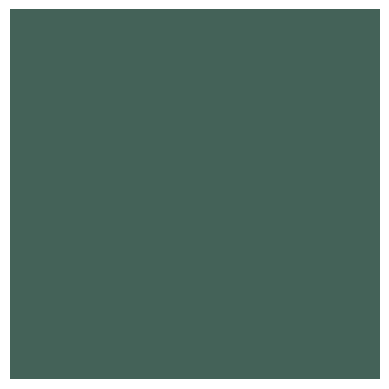

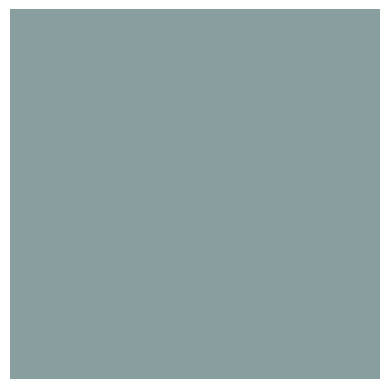

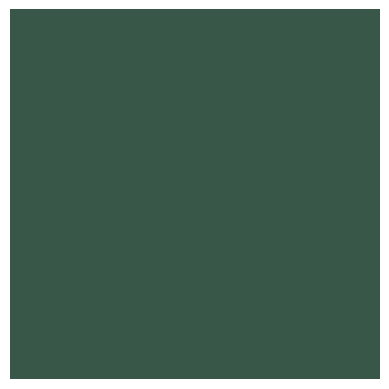

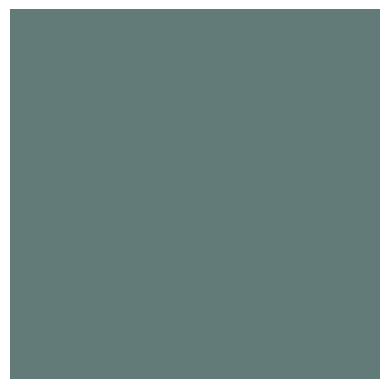

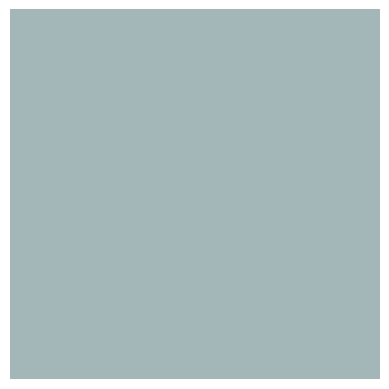

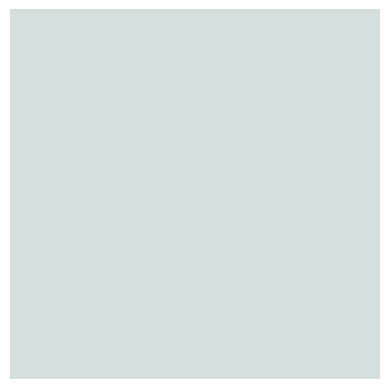

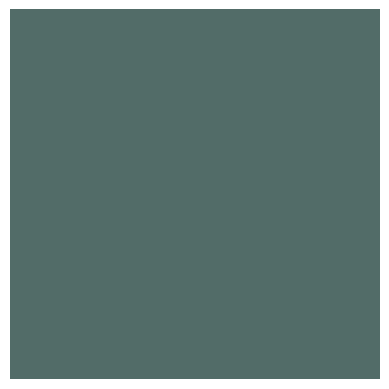

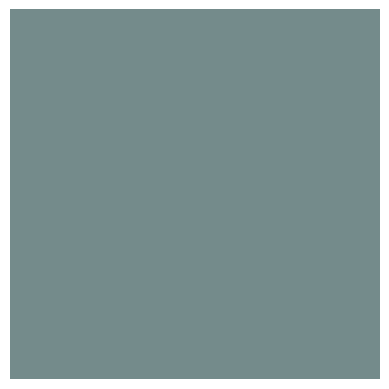

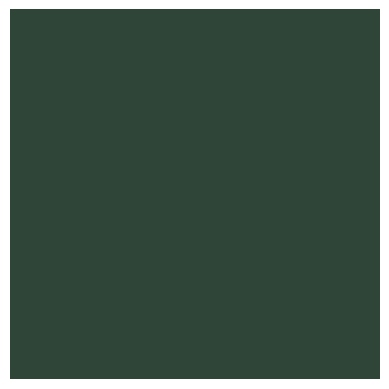

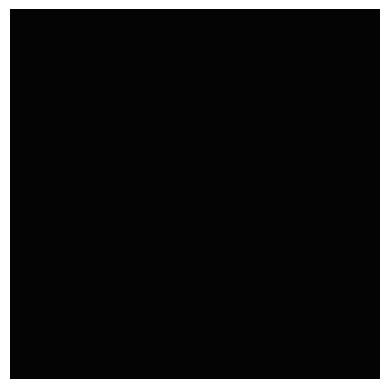

In [19]:
# Show the color families
for color_centroid in km.cluster_centers_:
    pixel_image = np.array([[np.rint(color_centroid).astype(int)]])
    
    plt.imshow(pixel_image)
    plt.axis("off")
    plt.show()

    

In [20]:
# Even just these clusters show that these images are 
# mostly tones of green

Three most popular color families:


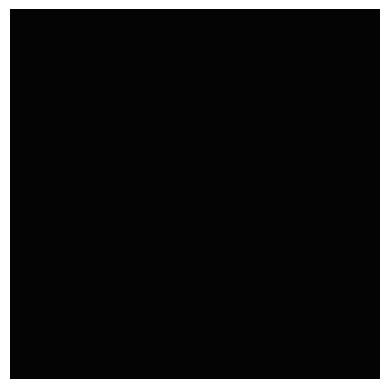

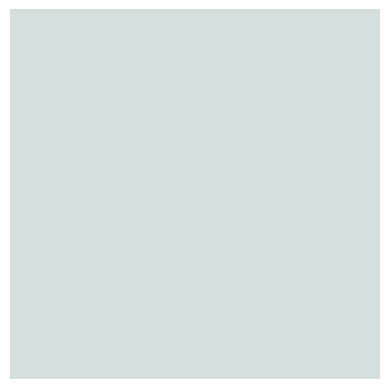

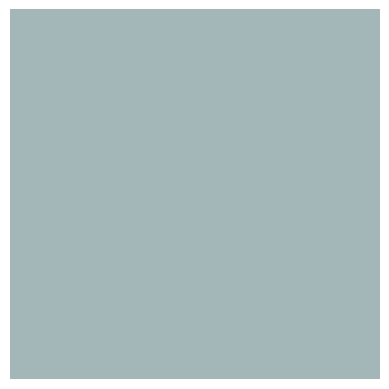

In [21]:
# Now, returning to the full set of colors,
# assign each to a cluster
# and see which clusters are more populous

pixel_clusters = km.predict(pixels)
pixel_clusters.shape

unique_clusters, cluster_counts = np.unique(pixel_clusters, return_counts=True)
cluster_popularity = list(zip(unique_clusters, cluster_counts))

popular_clusters = sorted(cluster_popularity, key=lambda x: x[1], reverse=False)

print("Three most popular color families:")

for i in range(3):
    cluster = popular_clusters[i][0]
    
    color_centroid = km.cluster_centers_[cluster]
    pixel_image = np.array([[np.rint(color_centroid).astype(int)]])
    
    plt.imshow(pixel_image)
    plt.axis("off")
    plt.show()

In [22]:
# Black and page green colors are the most popular color
# types in this set of images

Unique labels: [3 0 1 2]


Text(0, 0.5, 'Number of Images')

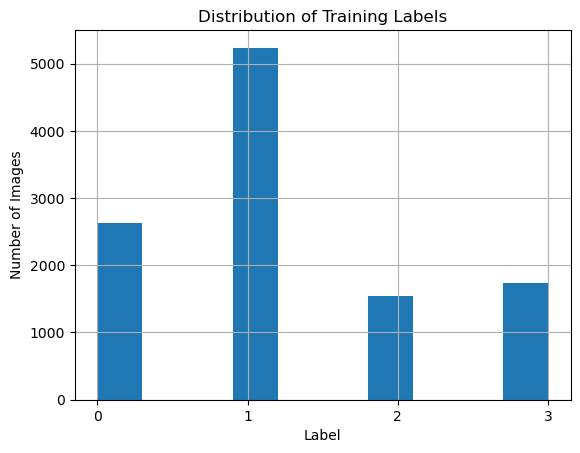

In [23]:
# Now, I'm going to turn to the labels

labels = pd.Series(train_labels)

print("Unique labels:", labels.unique())
labels.hist(align='mid')
plt.title("Distribution of Training Labels");
plt.xlabel("Label")
plt.xticks(labels.unique(), labels.unique())
plt.ylabel("Number of Images")

In [24]:
# There are 4 total labels, with label 1 being the most popular
# in fact label 1 is twice as frequent as any other label

# This might indicate the need to normalize the label
# frequency when creating training batches
# by downsampling label 1

# From the paper describing the data:

"""
0 (No Damage) - Undisturbed. No sgn of water, structural or shingle damage, or burn marks.
1 (Minor Damage) - Building partially burnt, water surrounding structure, volcanic flow nearby, roof elements missing, or visible cracks.
2 (Major Damage) - Partial wall or roof collapse, encroaching volcanic flow, or surrounded by water/mud.
3 (Destroyed) - Scorched, completely collapsed, partially/completely covered with water/mud, or otherwise no longer present.
"""

'\n0 (No Damage) - Undisturbed. No sgn of water, structural or shingle damage, or burn marks.\n1 (Minor Damage) - Building partially burnt, water surrounding structure, volcanic flow nearby, roof elements missing, or visible cracks.\n2 (Major Damage) - Partial wall or roof collapse, encroaching volcanic flow, or surrounded by water/mud.\n3 (Destroyed) - Scorched, completely collapsed, partially/completely covered with water/mud, or otherwise no longer present.\n'

In [25]:
# Now that I've gotten a lot of information out of the Hurricane data, I going to write a function 
# that will perform a similar analysis on the rest of the data sets and print out a summary

In [27]:
def summarize_eda(train_images, train_labels, disaster):
    
    print("Length of training set:", len(train_images))
    
    assert len(train_images) == len(train_labels)
    print("Same number of labels found")
    
    all_image_shapes = np.array([i.shape for i in train_images])
    
    if len(all_image_shapes[all_image_shapes[:,2] != 3]) == 0:
        print("All images have 3 RGB color channels")
    else:
        warnings.warn("SOME IMAGES ARENT RGB")
    
    print("Transforming all images to landscape...")
    train_images = list(map(orient_landscape, train_images))
    all_image_shapes = np.array([i.shape for i in train_images])
    
    
    print("Tallest image:")
    print(all_image_shapes[:,0].max())
    
    print("Widest image:")
    print(all_image_shapes[:,1].max())
    
    print("Shortest image:")
    print(all_image_shapes[:,0].min())
    
    print("Skinniest image:")
    print(all_image_shapes[:,1].min())
    
    heights = pd.Series(all_image_shapes[:,0])
    heights.hist()
    plt.title("Image Height Distribution for " + disaster)
    plt.xlabel("Height in Pixels")
    plt.ylabel("Number of Images")
    plt.show()
    
    
    widths = pd.Series(all_image_shapes[:,1])
    widths.hist()
    plt.title("Image Width Distribution for " + disaster)
    plt.xlabel("Width in Pixels")
    plt.ylabel("Number of Images")
    plt.show()
    
    
    pixels = np.concatenate([img.reshape((-1, 3)) for img in train_images], axis=0)
    print(len(pixels), "unique color pixels found")
    
    sampled_pixels = pixels[np.random.choice(range(len(pixels)), min(len(pixels), 10_000_000))]
    sampled_pixels.shape
    
    from sklearn.cluster import KMeans
    
    km = KMeans(n_clusters=10)
    km.fit(sampled_pixels)
    
    
    pixel_clusters = km.predict(pixels)
    pixel_clusters.shape
    
    unique_clusters, cluster_counts = np.unique(pixel_clusters, return_counts=True)
    cluster_popularity = list(zip(unique_clusters, cluster_counts))
    
    popular_clusters = sorted(cluster_popularity, key=lambda x: x[1], reverse=False)
    
    print("Three most popular color families:")
    
    for i in range(3):
        cluster = popular_clusters[i][0]
        
        color_centroid = km.cluster_centers_[cluster]
        pixel_image = np.array([[np.rint(color_centroid).astype(int)]])
        
        plt.imshow(pixel_image)
        plt.axis("off")
        plt.show()
    
    
    labels = pd.Series(train_labels)
    
    print("Unique labels:", labels.unique())
    labels.hist()
    plt.title("Distribution of Training Labels for " + disaster)
    plt.xlabel("Label")
    plt.ylabel("Number of Images")


Length of training set: 11151
Same number of labels found
All images have 3 RGB color channels
Transforming all images to landscape...
Tallest image:
396
Widest image:
296
Shortest image:
13
Skinniest image:
3


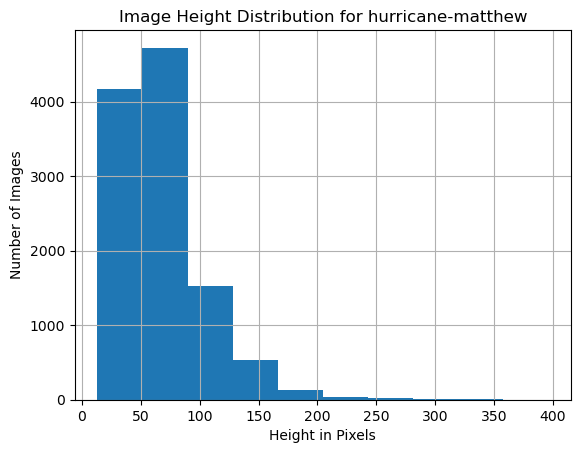

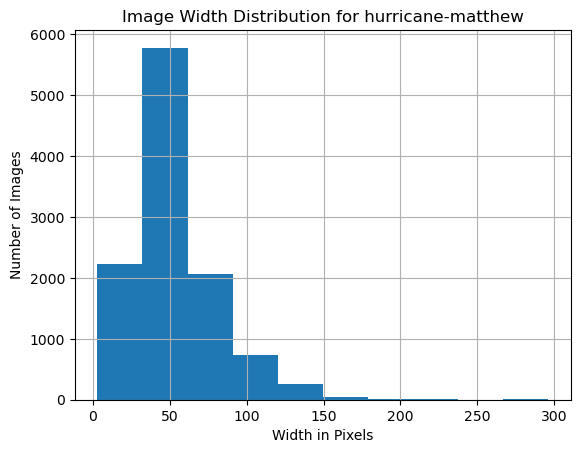

50104631 unique color pixels found
Three most popular color families:


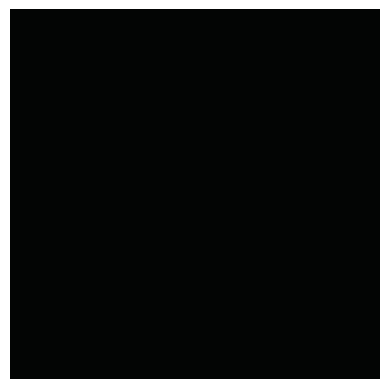

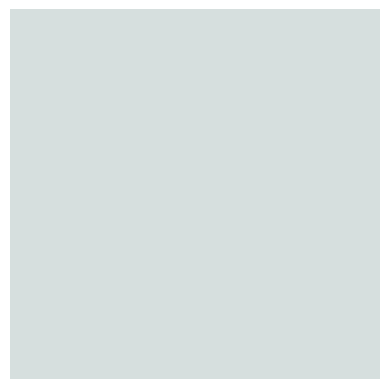

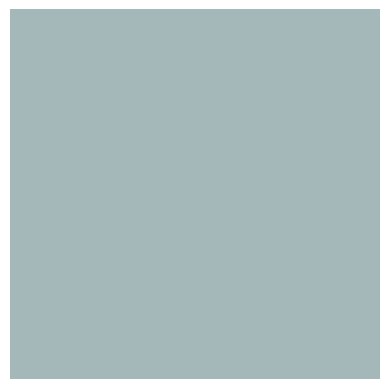

Unique labels: [3 0 1 2]


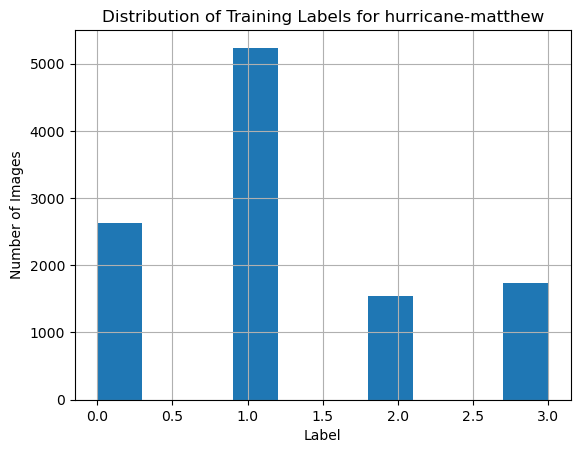

In [28]:
# Look at Hurricane-matthew
disaster = "hurricane-matthew"
split = "train"

# Load train data
hm_train_images = get_images(data_dir, disaster, split=split)
hm_train_labels = get_labels(data_dir, disaster, split=split)

summarize_eda(hm_train_images, hm_train_labels, disaster)

Length of training set: 8380
Same number of labels found
All images have 3 RGB color channels
Transforming all images to landscape...
Tallest image:
890
Widest image:
445
Shortest image:
13
Skinniest image:
3


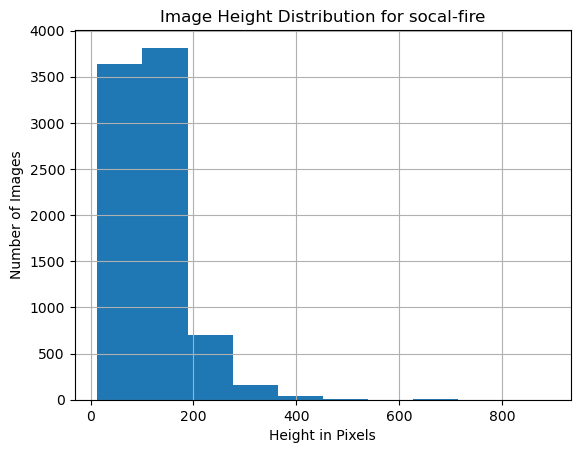

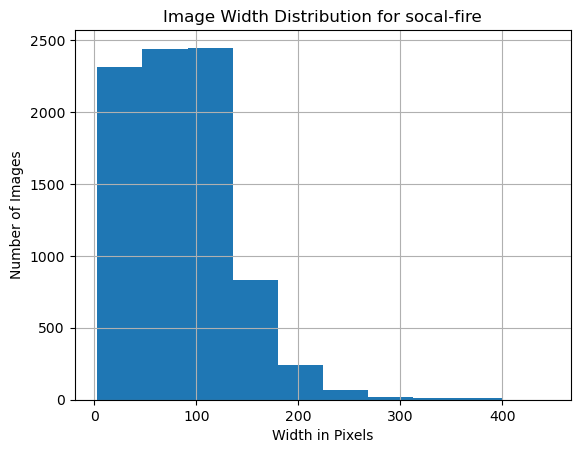

106778297 unique color pixels found
Three most popular color families:


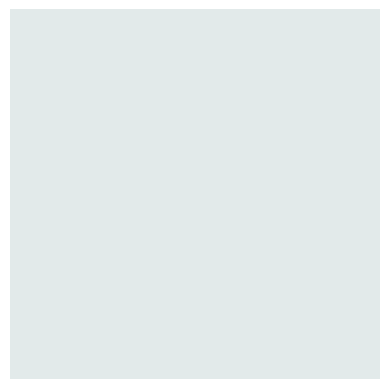

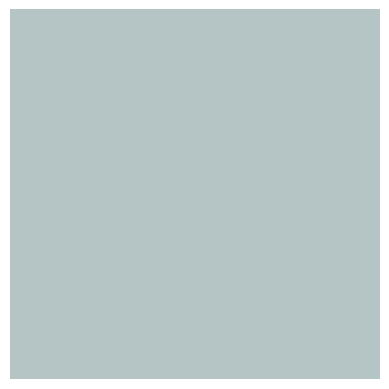

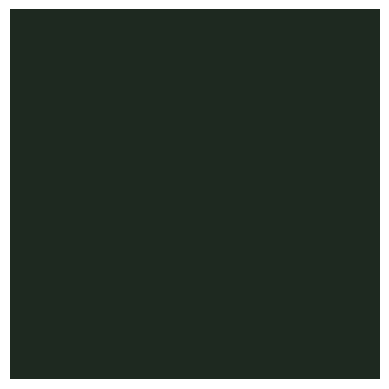

Unique labels: [0 3 2 1]


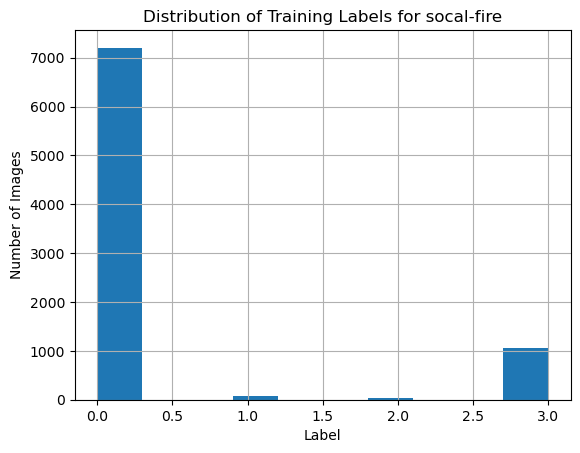

In [29]:
# Look at socal-fire
disaster = "socal-fire"
split = "train"

# Load train data
sf_train_images = get_images(data_dir, disaster, split=split)
sf_train_labels = get_labels(data_dir, disaster, split=split)

summarize_eda(sf_train_images, sf_train_labels, disaster)

Length of training set: 7004
Same number of labels found
All images have 3 RGB color channels
Transforming all images to landscape...
Tallest image:
863
Widest image:
508
Shortest image:
14
Skinniest image:
3


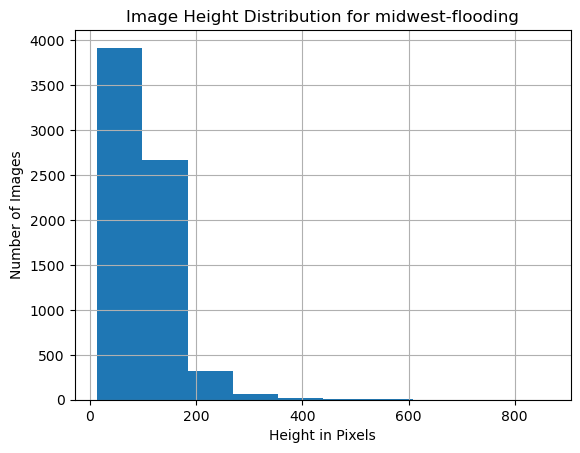

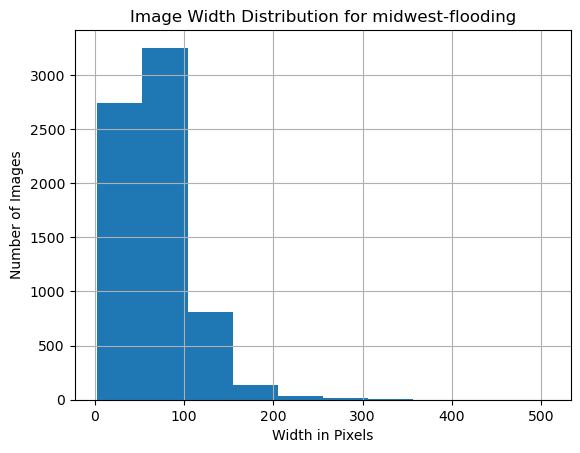

59904622 unique color pixels found
Three most popular color families:


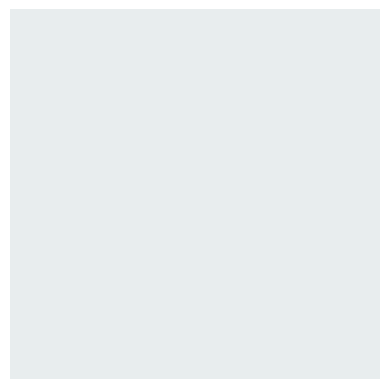

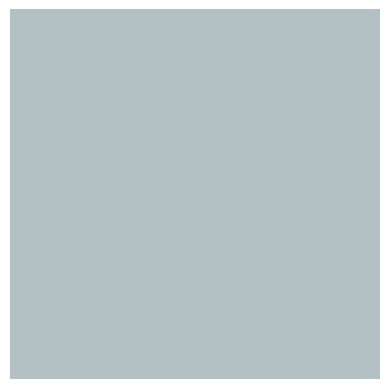

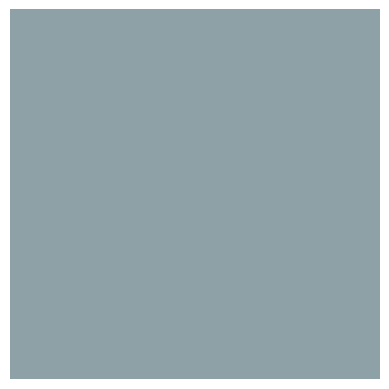

Unique labels: [0 1 3 2]


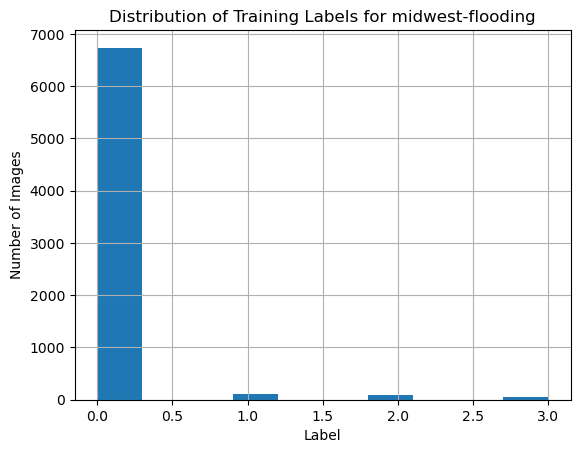

In [30]:
# Look at socal-fire
disaster = "midwest-flooding"
split = "train"

# Load train data
mf_train_images = get_images(data_dir, disaster, split=split)
mf_train_labels = get_labels(data_dir, disaster, split=split)

summarize_eda(mf_train_images, mf_train_labels, disaster)

In [42]:
# From this, we can see the hurricane data set is the largest, and has the most uniform frequency of each label

# The socal-fire data has mostly 0s, and then a substantial amount of 3s. Very "all or nothing" in terms of the destruction.

# The mid-west flood data also has mostly 0s, with the other categories much lower, but those category frequencies are similar
# to each other

# Suprisingly, the most popular color families for each are about the same. 
# This might be because all of the images are satelite images, and likely see a lot of green-ish grass, pavement, etc. 
# So it might be helpful to look for outlier colors instead of most popular colors

In [43]:
# Initial thoughts:

# Major challenges - 
    # non-uniform distribution of labels
    # *some* pictures of dramatically different sizes (though most are in the same range)
    # many images from different disasters/labels have the same color pallete since they are all satelite images with green and black

# Places to explore next - 
    # re-assess the colors in the images - perhaps look for outlier pixels relative to the dataset's overall pallete
    # Think about image transforms to deal with the different sizes, research architectures that could handle this

In [44]:
hm_pixels = np.concatenate([img.reshape((-1, 3)) for img in hm_train_images], axis=0)
sf_pixels = np.concatenate([img.reshape((-1, 3)) for img in sf_train_images], axis=0)
mf_pixels = np.concatenate([img.reshape((-1, 3)) for img in mf_train_images], axis=0)

#all_pixels = np.concatenate(hm_pixels + sf_pixels + mf_pixels, axis=0)
mf_pixels.shape

(59904622, 3)

In [45]:
from matplotlib import colors

In [46]:
colors.CSS4_COLORS

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [47]:
import numpy as np
from matplotlib import colors

# Get colors dictionary
name_to_hex = colors.CSS4_COLORS
hex_to_name = {h: n for n, h in name_to_hex.items()}

color_rgb_values = np.array([np.array(colors.hex2color(hexvalue)) for hexvalue in name_to_hex.values()]) * 255

def compare(rgb_colors):
    if not isinstance(rgb_colors, np.ndarray):
        rgb_colors = np.array(rgb_colors)
    
    # Reshape color array to be 3D if it's 1D
    if rgb_colors.ndim == 1:
        rgb_colors = rgb_colors.reshape(1, -1)
    
    # Compute distances to all colors in one go
    distances = np.linalg.norm(color_rgb_values[:, np.newaxis, :] - rgb_colors, axis=2)
    
    # Find the index of the closest color for each input RGB color
    closest_indices = np.argmin(distances, axis=0)
    
    # Get the names of the closest colors
    closest_colors = [list(name_to_hex.keys())[idx] for idx in closest_indices]
    
    return closest_colors


def compare(rgb_colors, chunk_size=100000):
    if not isinstance(rgb_colors, np.ndarray):
        rgb_colors = np.array(rgb_colors)
    
    # Reshape color array to be 3D if it's 1D
    if rgb_colors.ndim == 1:
        rgb_colors = rgb_colors.reshape(1, -1)
    
    num_colors = rgb_colors.shape[0]
    closest_colors = []
    
    # Process colors in chunks
    for i in range(0, num_colors, chunk_size):
        chunk = rgb_colors[i:i+chunk_size]
        
        # Compute distances to all colors in the current chunk
        distances = np.linalg.norm(color_rgb_values[:, np.newaxis, :] - chunk, axis=2)
        
        # Find the index of the closest color for each input RGB color in the chunk
        closest_indices = np.argmin(distances, axis=0)
        
        # Get the names of the closest colors
        chunk_closest_colors = [list(name_to_hex.keys())[idx] for idx in closest_indices]
        
        closest_colors.extend(chunk_closest_colors)
    
    return closest_colors


In [48]:
%%time

hm_pixels_color_names = compare(hm_pixels)
#pd.Series(hm_pixels_color_names).hist()
#plt.xticks(rotation=90)

#plt.title("HURRICANE")
#plt.show()
 

sf_pixels_color_names = compare(sf_pixels)
#pd.Series(sf_pixels_color_names).hist()
#plt.xticks(rotation=90)

#plt.title("FIRE")
#plt.show()

mf_pixels_color_names = compare(mf_pixels)
#pd.Series(mf_pixels_color_names).hist()
#plt.xticks(rotation=90)

#plt.title("FLOOD")
#plt.show()

CPU times: user 11min 22s, sys: 2min 16s, total: 13min 38s
Wall time: 13min 43s


In [49]:
hm_pixels_color_names = pd.Series(hm_pixels_color_names)
hm_pixels_color_names = hm_pixels_color_names[~hm_pixels_color_names.str.contains("gray")]

In [50]:
sf_pixels_color_names = pd.Series(sf_pixels_color_names)
sf_pixels_color_names = sf_pixels_color_names[~sf_pixels_color_names.str.contains("gray")]

In [51]:
mf_pixels_color_names = pd.Series(mf_pixels_color_names)
mf_pixels_color_names = mf_pixels_color_names[~mf_pixels_color_names.str.contains("gray")]

In [52]:
import matplotlib

In [53]:
import importlib
importlib.reload(matplotlib)

<module 'matplotlib' from '/Users/chu/miniconda3/envs/ds200s/lib/python3.12/site-packages/matplotlib/__init__.py'>

In [54]:
plt.rc('font', size=45)          # controls default text sizes

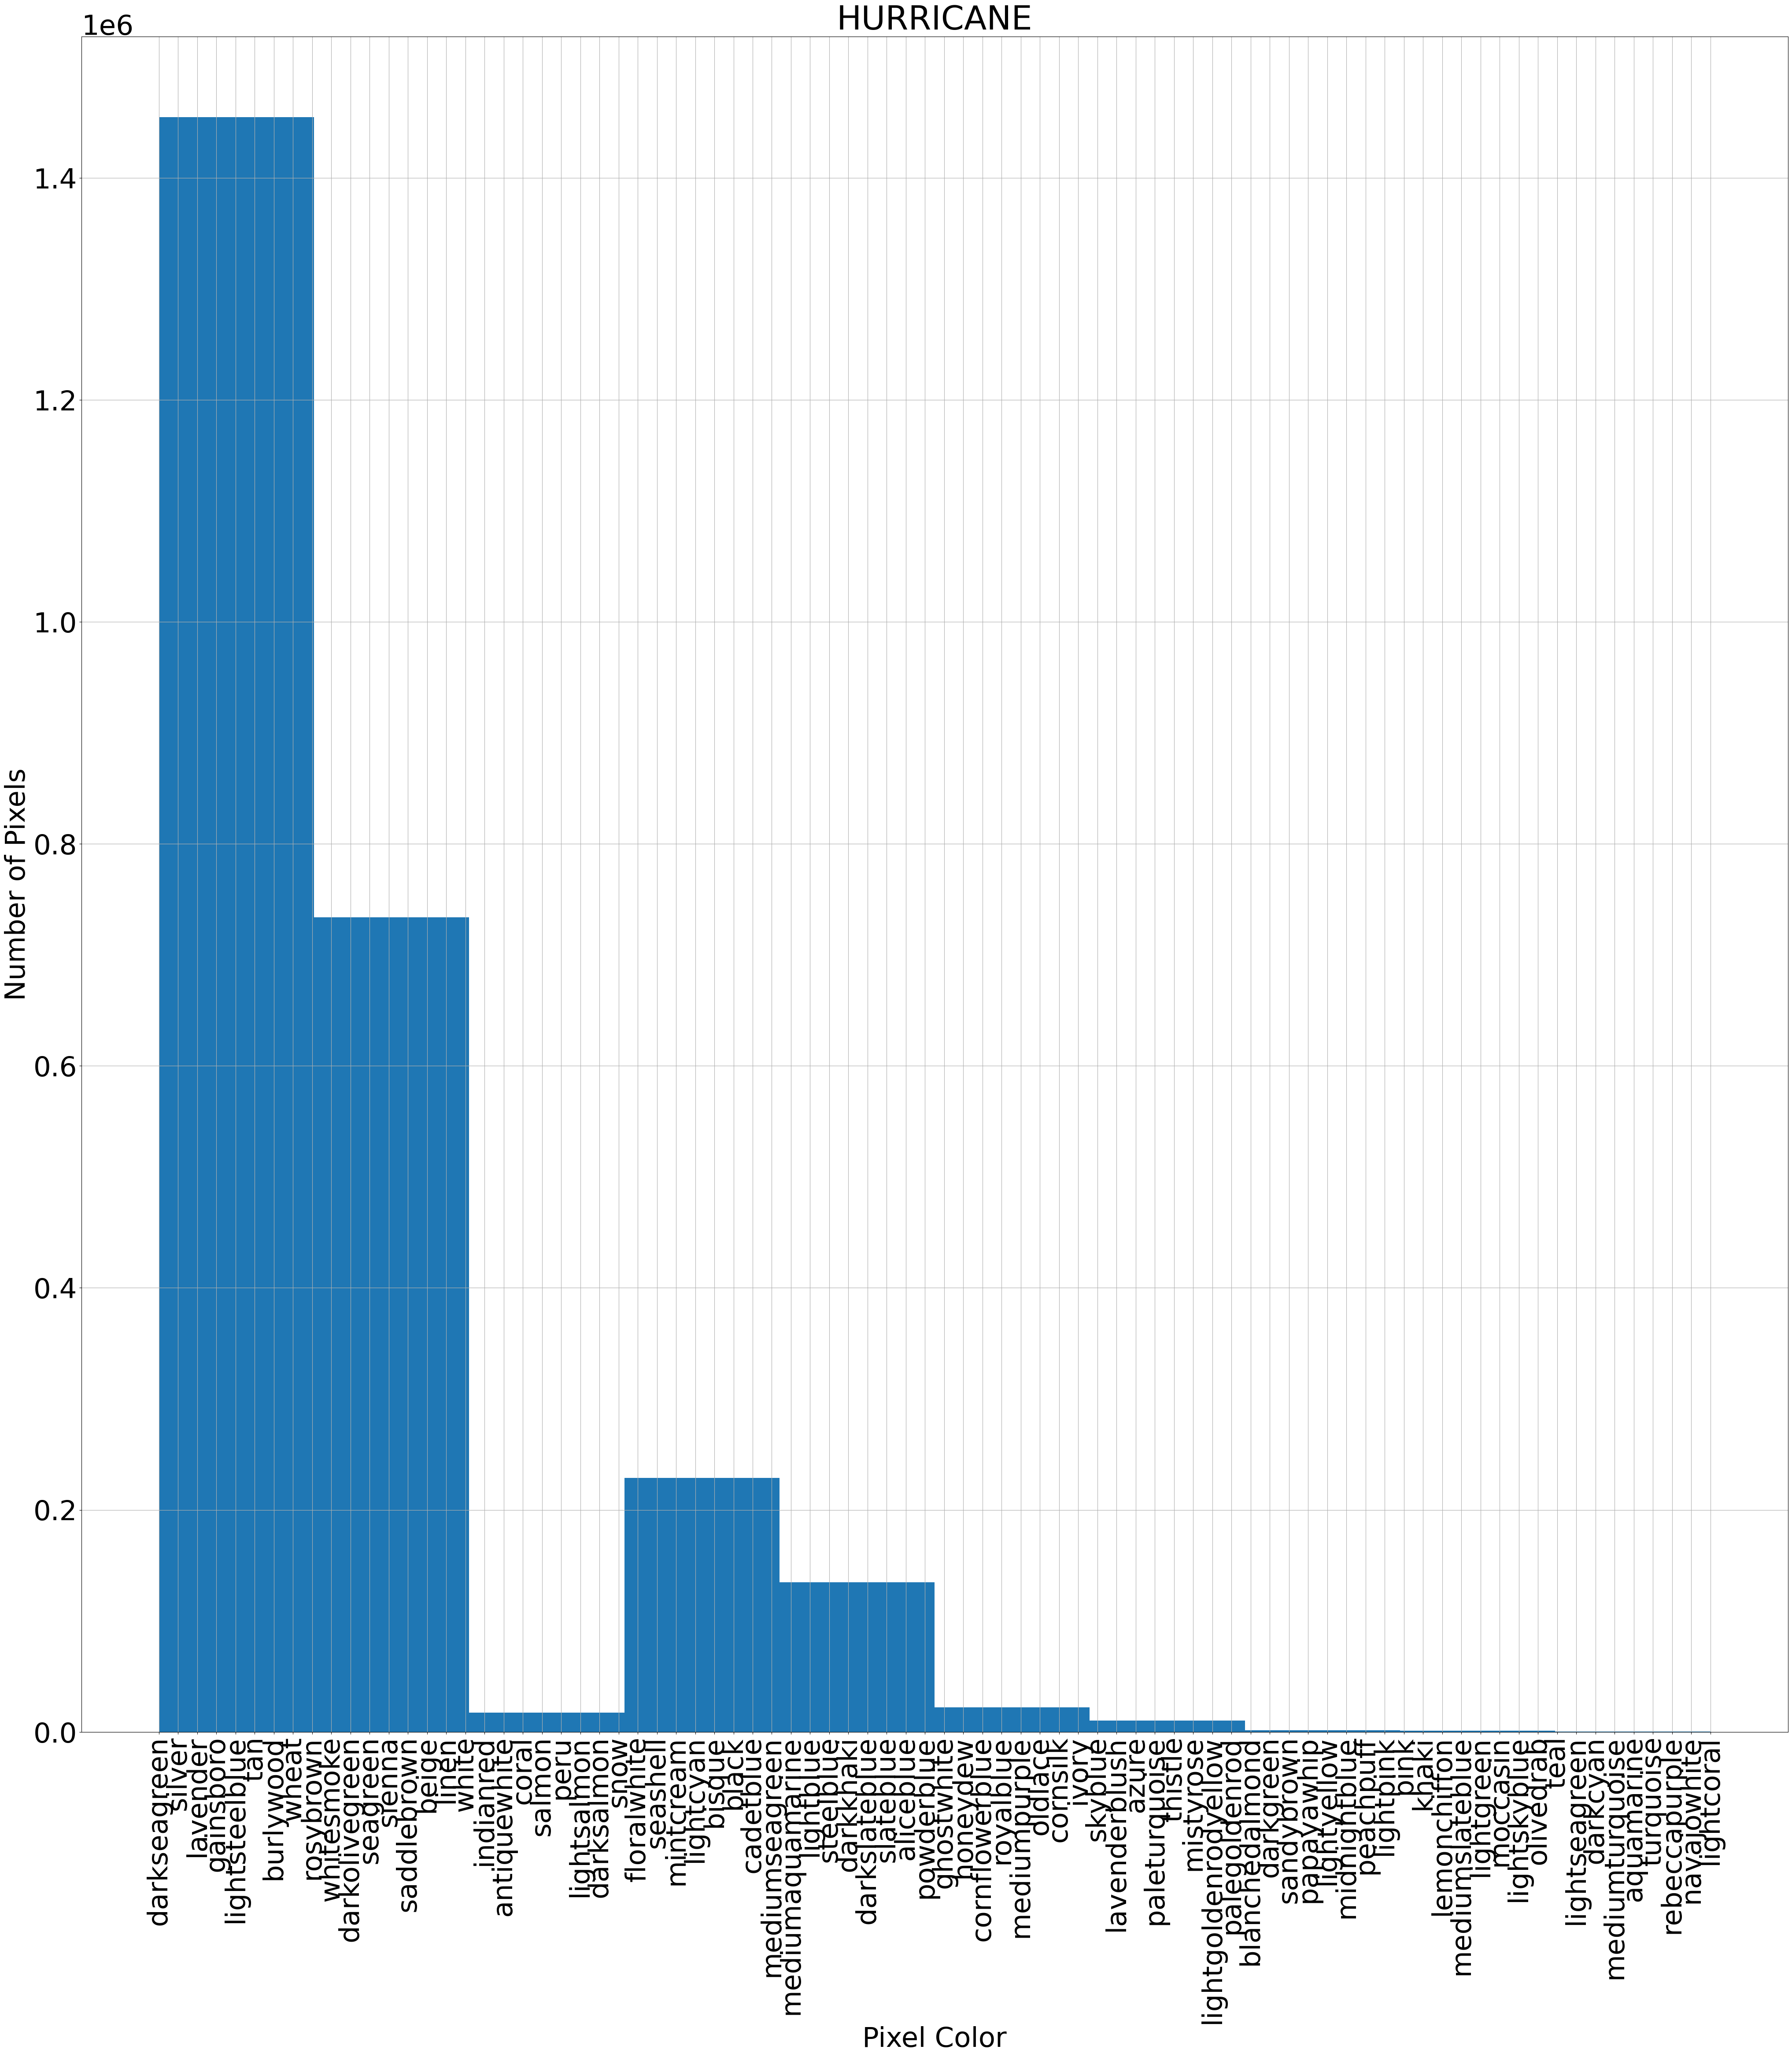

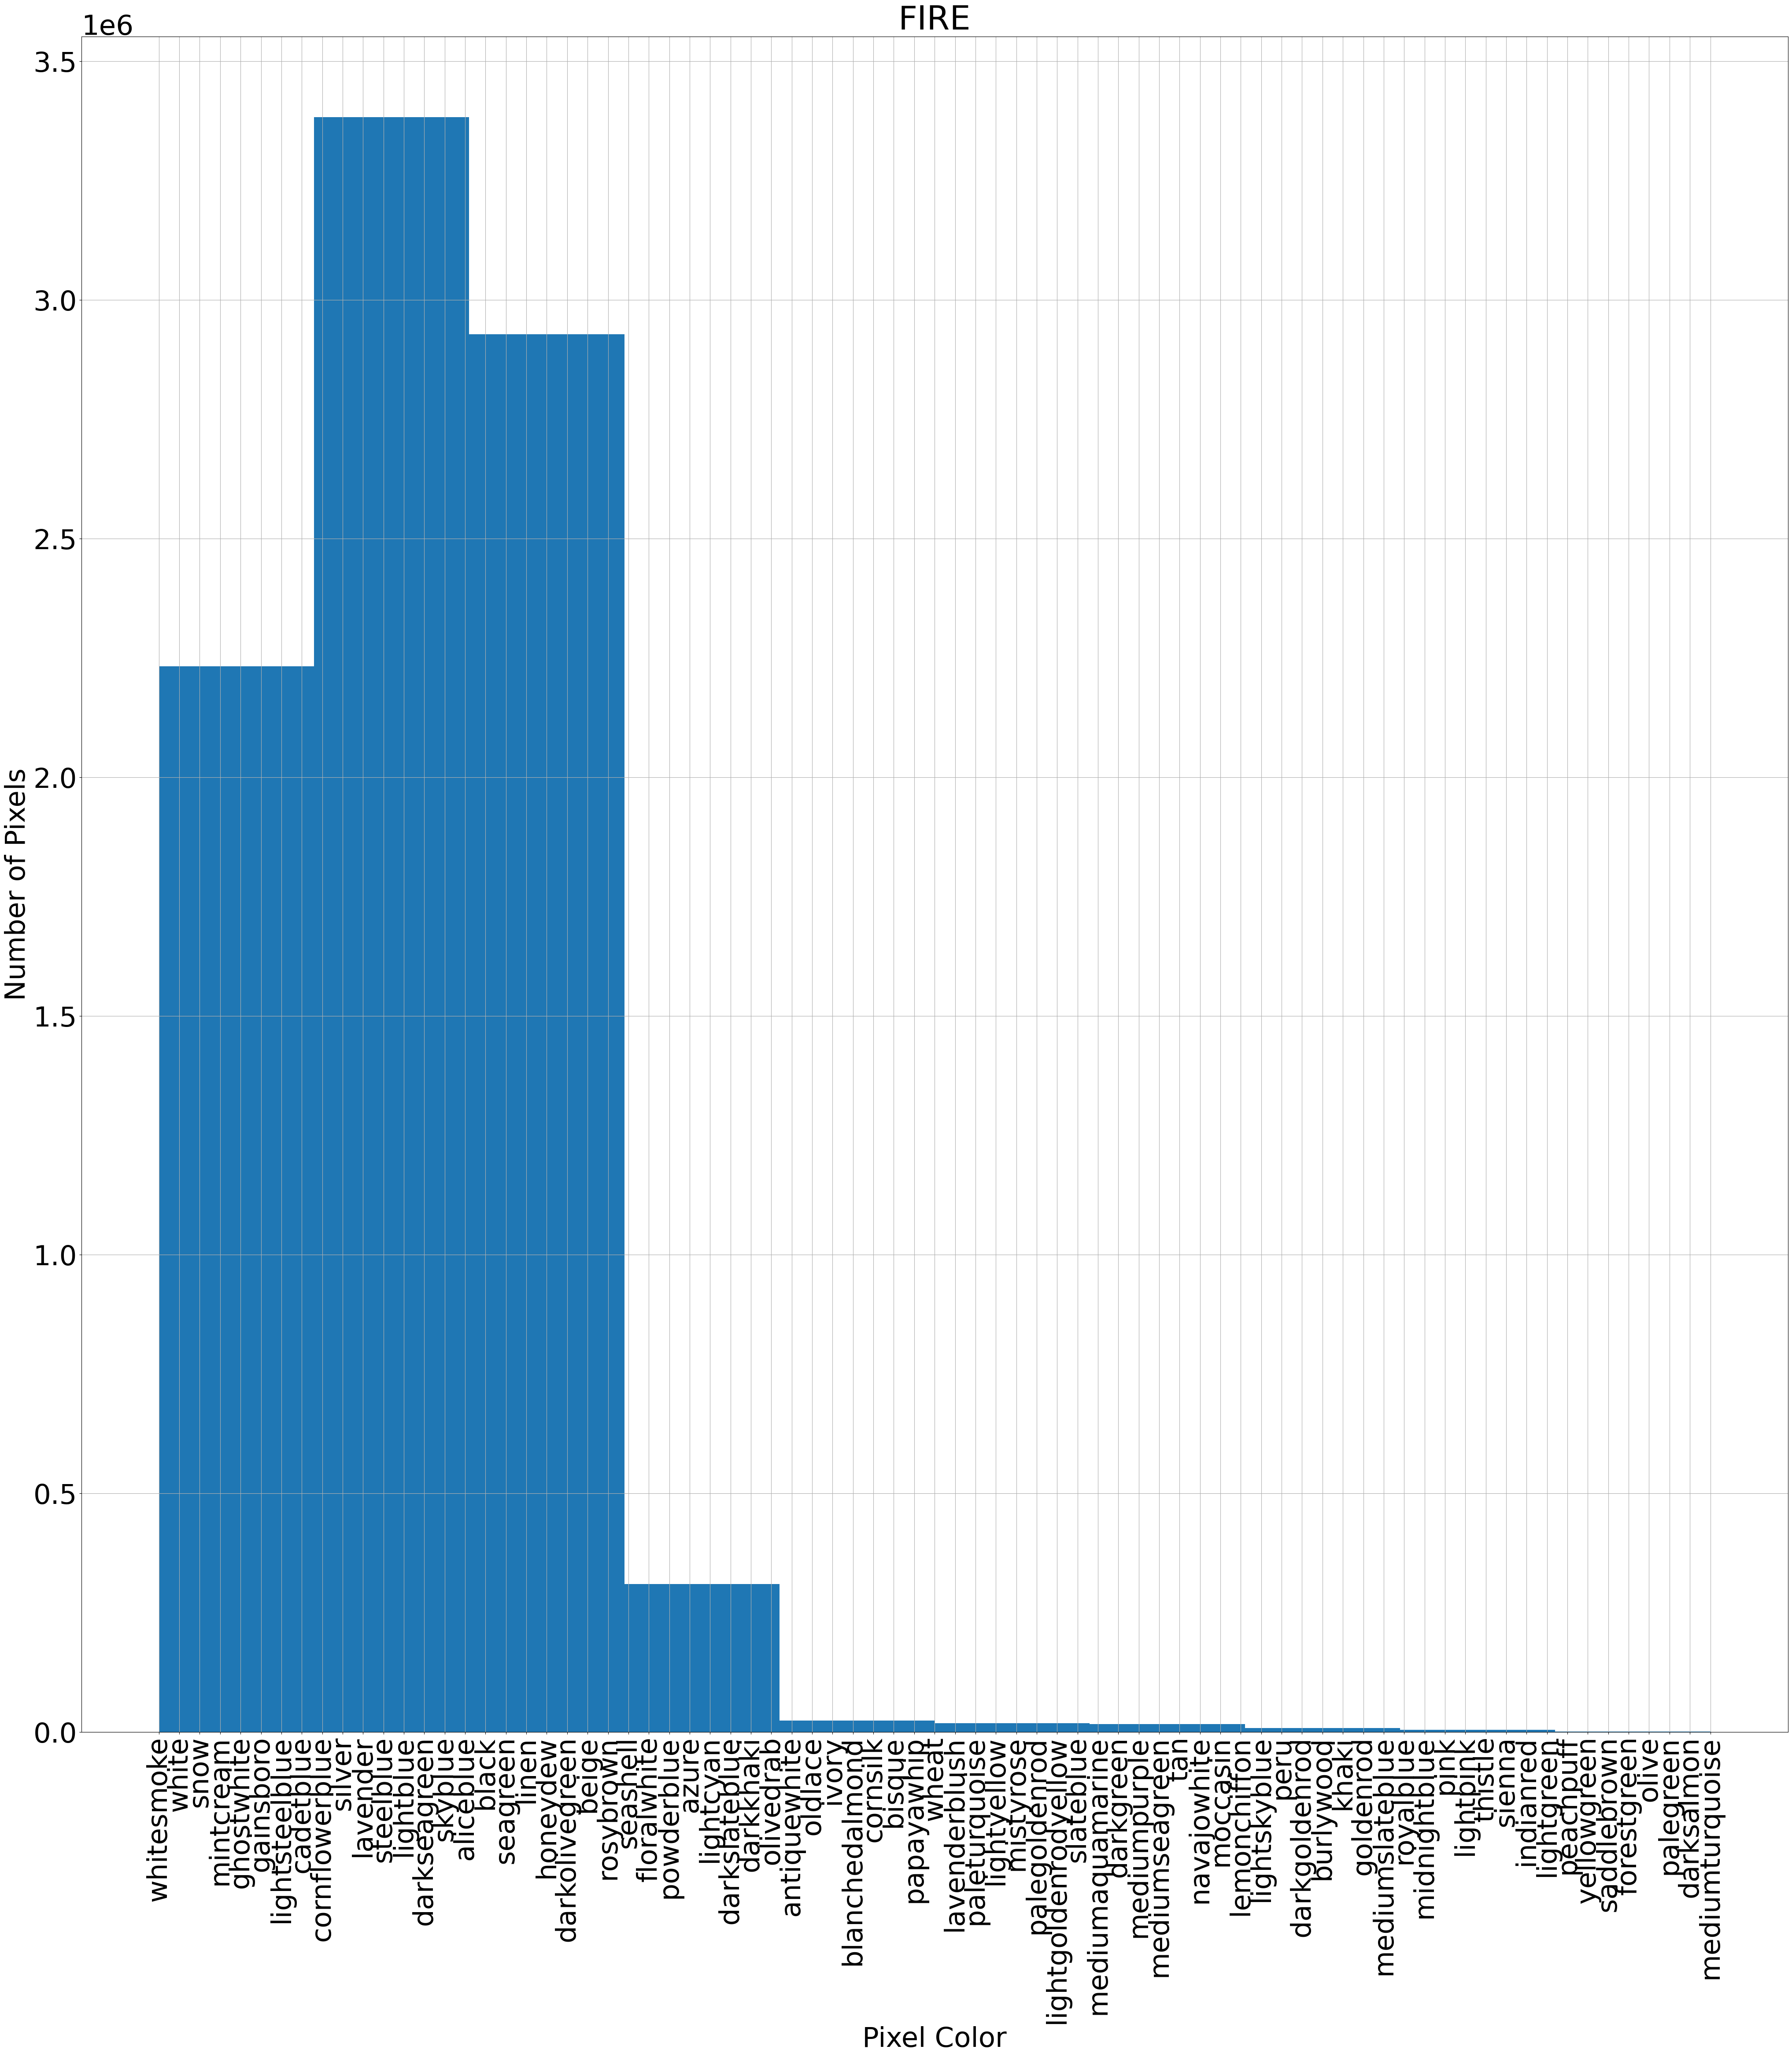

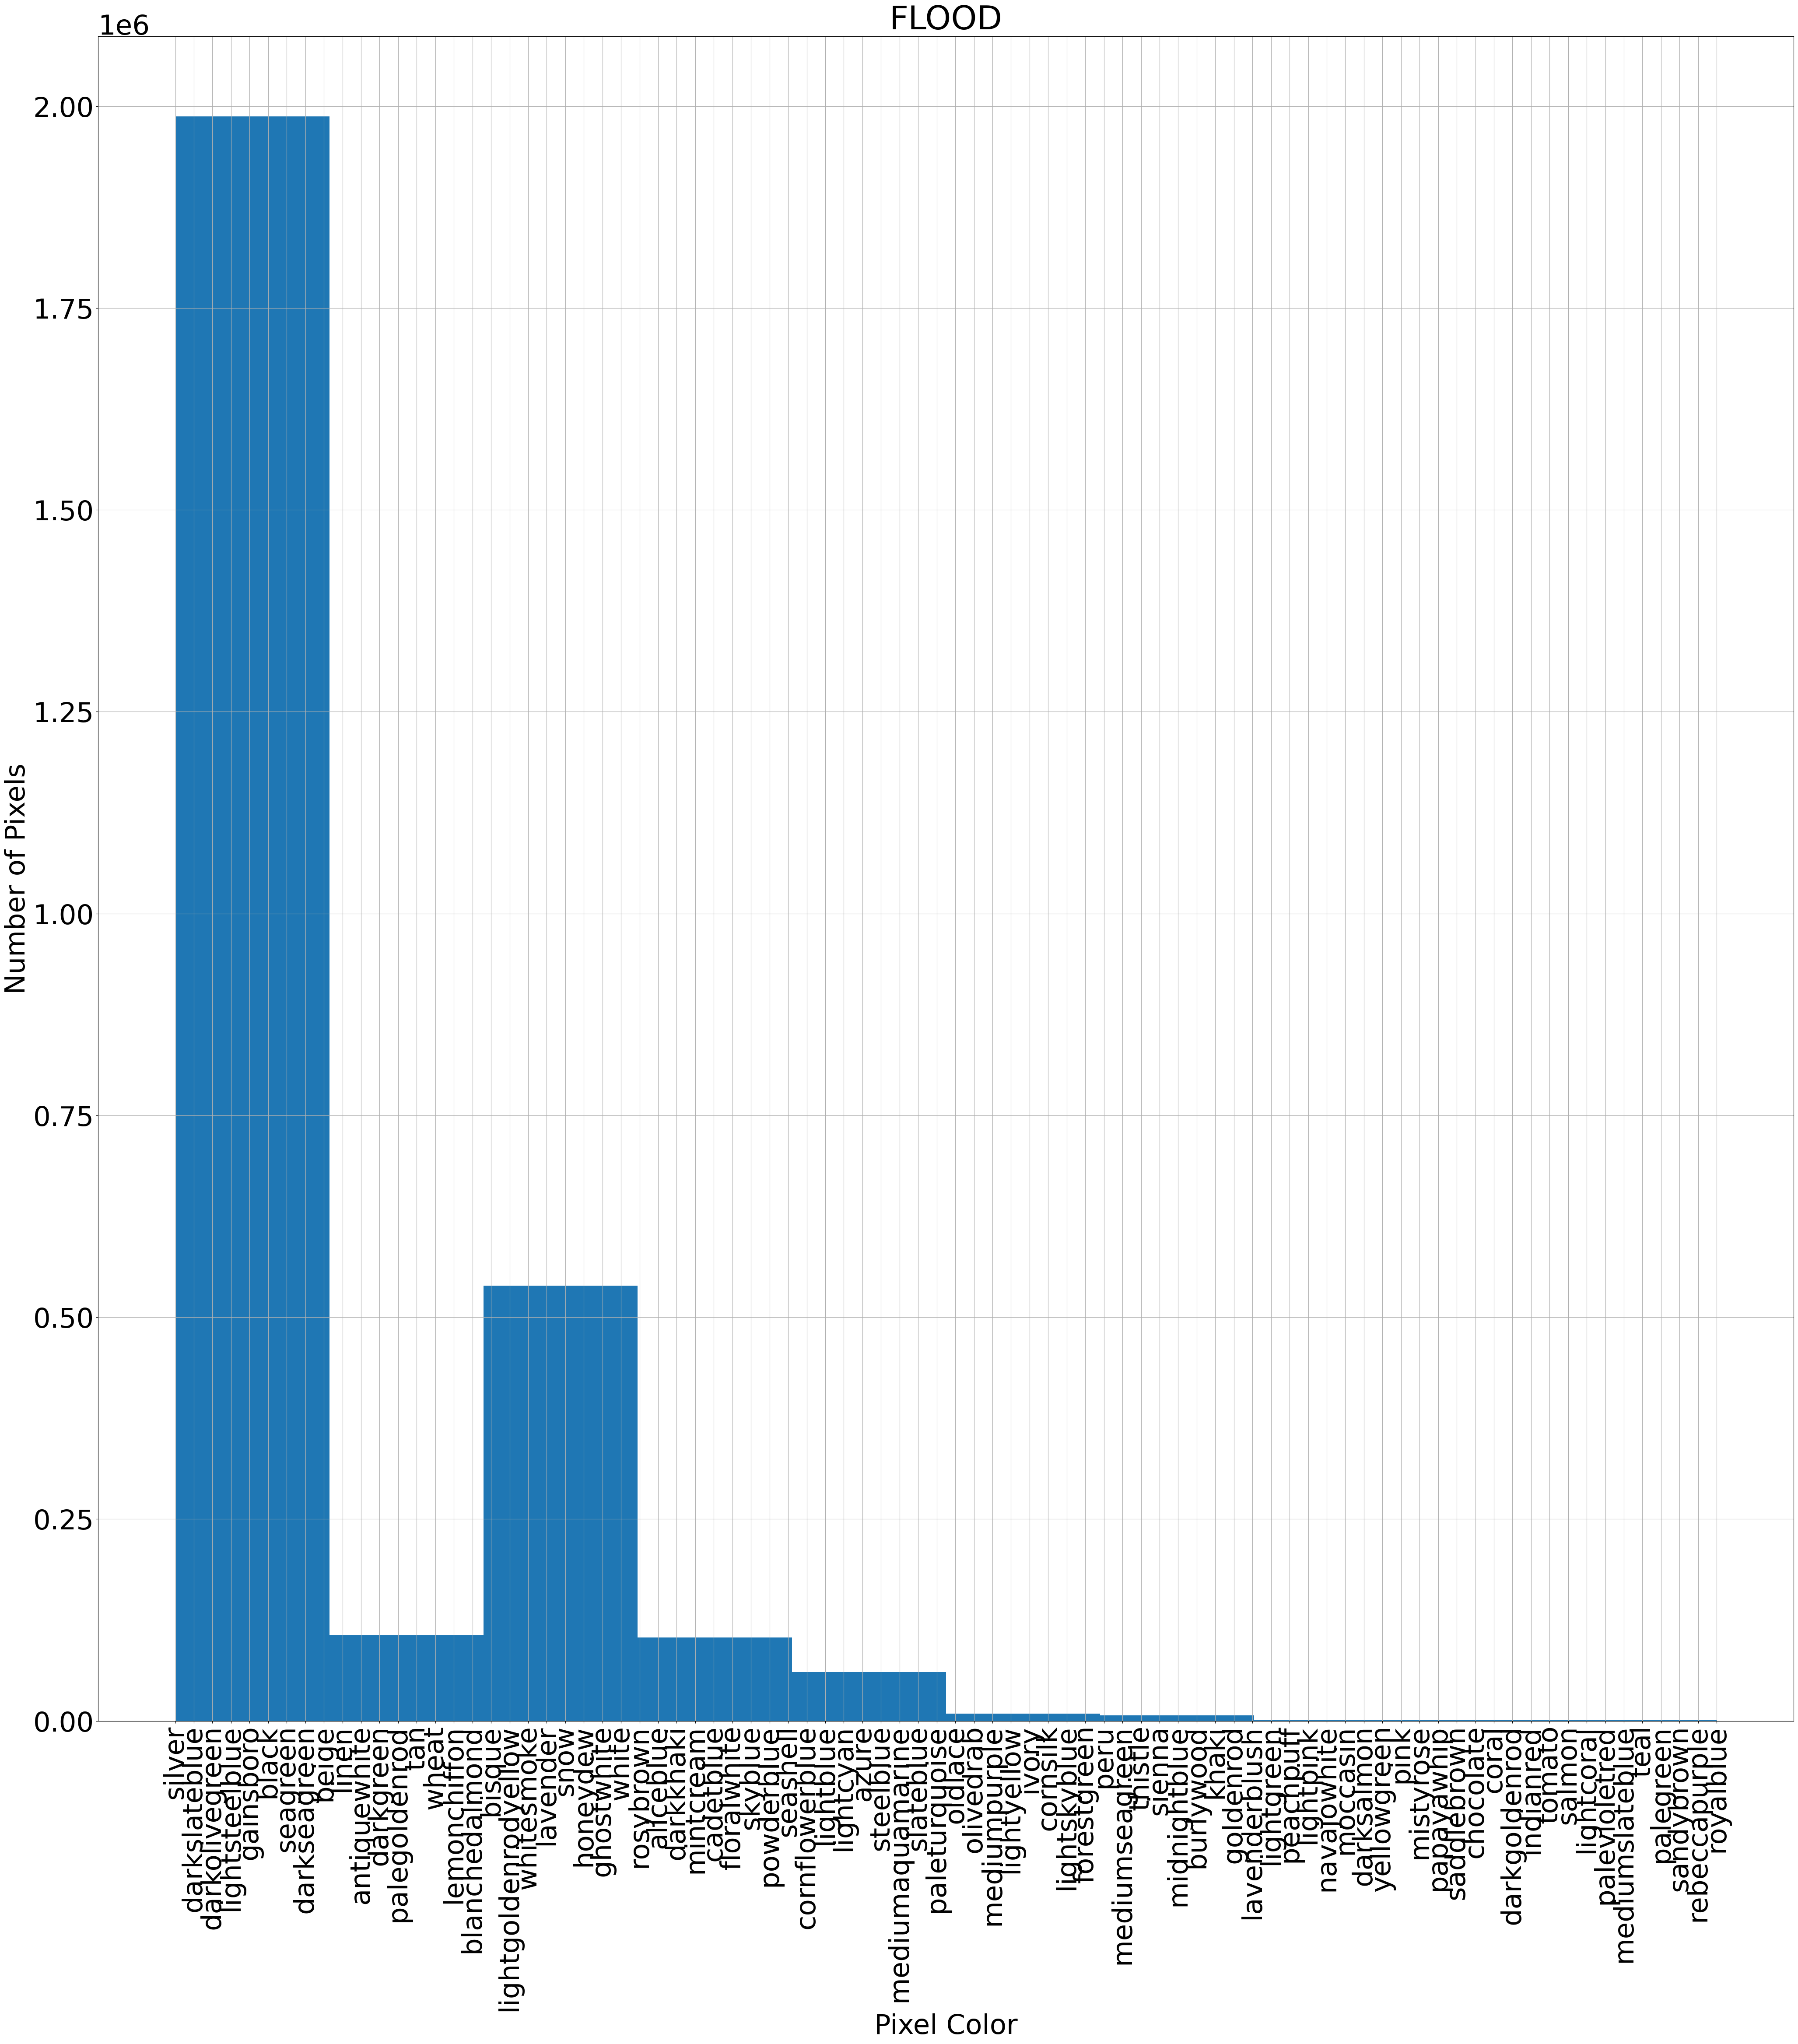

In [55]:
#hm_pixels_color_names = compare(hm_pixels)
plt.figure(figsize=(50,50))
hm_pixels_color_names.hist()
plt.xticks(rotation=90)

plt.title("HURRICANE")
plt.ylabel("Number of Pixels")
plt.xlabel("Pixel Color")
plt.show()
 

#sf_pixels_color_names = compare(sf_pixels)
plt.figure(figsize=(50,50))
sf_pixels_color_names.hist()
plt.xticks(rotation=90)

plt.title("FIRE")
plt.ylabel("Number of Pixels")
plt.xlabel("Pixel Color")
plt.show()

#mf_pixels_color_names = compare(mf_pixels)
plt.figure(figsize=(50,50))
mf_pixels_color_names.hist()
plt.xticks(rotation=90)

plt.title("FLOOD")
plt.ylabel("Number of Pixels")
plt.xlabel("Pixel Color")
plt.show()

In [47]:
hm_color_df = mf_pixels_color_names.value_counts().to_frame().reset_index().rename({"index":"color", "count":"hm_count"}, axis=1)

In [48]:
sf_color_df = sf_pixels_color_names.value_counts().to_frame().reset_index().rename({"index":"color", "count":"sf_count"}, axis=1)

In [49]:
mf_color_df = mf_pixels_color_names.value_counts().to_frame().reset_index().rename({"index":"color", "count":"mf_count"}, axis=1)

In [50]:
all_colors = hm_color_df.merge(sf_color_df, on="color", how="outer").merge(mf_color_df, on="color", how="outer")

In [51]:
all_colors

,color,hm_count,sf_count,mf_count
0,aliceblue,22609.0,78878.0,22609.0
1,antiquewhite,2908.0,8674.0,2908.0
2,azure,2656.0,8711.0,2656.0
3,beige,6846.0,27361.0,6846.0
4,bisque,491.0,1765.0,491.0
...,...,...,...,...
81,tomato,2.0,NaN,2.0
82,wheat,1330.0,4085.0,1330.0
83,white,117899.0,123024.0,117899.0
84,whitesmoke,162771.0,208753.0,162771.0


In [52]:
from scipy import stats

In [64]:
all_colors = all_colors.fillna(0)

In [65]:
all_colors["hm_percentile"] = all_colors["hm_count"].apply(lambda x: stats.percentileofscore(all_colors["hm_count"], x, kind='weak', nan_policy='omit'))

In [66]:
all_colors["sf_percentile"] = all_colors["sf_count"].apply(lambda x: stats.percentileofscore(all_colors["sf_count"], x, kind='weak', nan_policy='omit'))

In [67]:
all_colors["mf_percentile"] = all_colors["mf_count"].apply(lambda x: stats.percentileofscore(all_colors["mf_count"], x, kind='weak', nan_policy='omit'))

In [68]:
all_colors

,color,hm_count,sf_count,mf_count,hm_percentile,sf_percentile,mf_percentile
0,aliceblue,22609.0,78878.0,22609.0,80.232558,83.720930,80.232558
1,antiquewhite,2908.0,8674.0,2908.0,68.604651,66.279070,68.604651
2,azure,2656.0,8711.0,2656.0,67.441860,67.441860,67.441860
3,beige,6846.0,27361.0,6846.0,73.255814,75.581395,73.255814
4,bisque,491.0,1765.0,491.0,45.348837,50.000000,45.348837
...,...,...,...,...,...,...,...
81,tomato,2.0,0.0,2.0,5.813953,10.465116,5.813953
82,wheat,1330.0,4085.0,1330.0,52.325581,58.139535,52.325581
83,white,117899.0,123024.0,117899.0,89.534884,84.883721,89.534884
84,whitesmoke,162771.0,208753.0,162771.0,90.697674,88.372093,90.697674


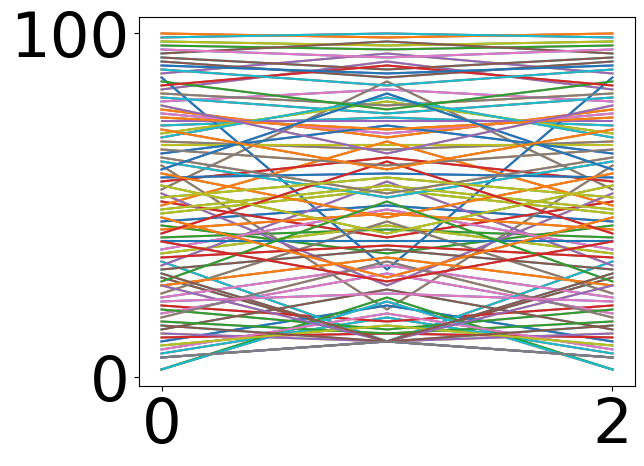

In [74]:
for i, row in all_colors.iterrows():

    plt.plot([0, 1, 2], row[["hm_percentile", "sf_percentile", "mf_percentile"]].values)

plt.show()

In [82]:
# there are at least some colors that have high in something and low in others

all_colors[
    (all_colors["sf_percentile"] > 75) & (all_colors["hm_percentile"] < 60) & (all_colors["mf_percentile"] < 60) 
]

,color,hm_count,sf_count,mf_count,hm_percentile,sf_percentile,mf_percentile
11,cornflowerblue,1484.0,159868.0,1484.0,54.651163,86.046512,54.651163


In [83]:
all_colors[
    (all_colors["sf_percentile"] < 50) & (all_colors["hm_percentile"] > 60) & (all_colors["mf_percentile"] > 60) 
]

,color,hm_count,sf_count,mf_count,hm_percentile,sf_percentile,mf_percentile
14,darkgreen,58705.0,327.0,58705.0,87.209302,31.395349,87.209302
21,forestgreen,2056.0,27.0,2056.0,61.627907,19.767442,61.627907
